In [2]:
import sys
import os
sys.path.append(os.path.abspath("Pytorch/"))
sys.path.append(os.path.abspath("models/"))

In [3]:
from FBSNNs import *
from CallOption import *

In [4]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import time

M = 128  # number of trajectories (batch size)
N = 500  # number of time snapshots
D = 1 # number of dimensions
Mm = N ** (1/5)

layers = [D + 1] + 4 * [256] + [1]

Xi = np.array([1.0] * D)[None, :]
T = 1.0

"Available architectures"
mode = "NAIS-Net"  # FC, Resnet and NAIS-Net are available
activation = "Sine"  # Sine and ReLU are available
model = CallOption(Xi, T, M, N, D, Mm, layers, mode, activation)

n_iter = 5 * 10 ** 3
lr = 1e-5

In [5]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import time

M = 1  # number of trajectories (batch size)
N = 500  # number of time snapshots
D = 1 # number of dimensions
Mm = N ** (1/5)

layers = [D + 1] + 4 * [256] + [1]

Xi = np.array([1.0] * D)[None, :]
T = 1.0

"Available architectures"
mode = "NAIS-Net"  # FC, Resnet and NAIS-Net are available
activation = "Sine"  # Sine and ReLU are available
model2 = CallOption(Xi, T, M, N, D, Mm, layers, mode, activation)

n_iter = 5 * 10 ** 3
lr = 1e-5

In [6]:
model.load_model("models/CallOption.pth")

In [25]:
tot = time.time()
print(model.device)
graph = model.train(n_iter, lr)
print("total time:", time.time() - tot, "s")

cuda:0
It: 29700, Loss: 6.777e-01, Y0: 0.184, Time: 0.64, Learning Rate: 1.000e-05
It: 29800, Loss: 7.763e-01, Y0: 0.181, Time: 63.85, Learning Rate: 1.000e-05
It: 29900, Loss: 5.516e-01, Y0: 0.180, Time: 63.58, Learning Rate: 1.000e-05
It: 30000, Loss: 7.666e-01, Y0: 0.182, Time: 63.53, Learning Rate: 1.000e-05
It: 30100, Loss: 6.938e-01, Y0: 0.180, Time: 65.45, Learning Rate: 1.000e-05
It: 30200, Loss: 9.380e-01, Y0: 0.180, Time: 64.21, Learning Rate: 1.000e-05
It: 30300, Loss: 7.118e-01, Y0: 0.180, Time: 64.11, Learning Rate: 1.000e-05
It: 30400, Loss: 7.228e-01, Y0: 0.181, Time: 64.28, Learning Rate: 1.000e-05
It: 30500, Loss: 6.186e-01, Y0: 0.181, Time: 64.08, Learning Rate: 1.000e-05
It: 30600, Loss: 7.338e-01, Y0: 0.181, Time: 64.08, Learning Rate: 1.000e-05
It: 30700, Loss: 9.790e-01, Y0: 0.179, Time: 63.80, Learning Rate: 1.000e-05
It: 30800, Loss: 8.412e-01, Y0: 0.179, Time: 64.45, Learning Rate: 1.000e-05
It: 30900, Loss: 9.343e-01, Y0: 0.180, Time: 64.57, Learning Rate: 1.0

In [10]:
graph = model.iteration, model.training_loss

In [15]:
t_test, W_test = model.fetch_minibatch()
X_pred, Y_pred = model.predict(Xi, t_test, W_test)

if type(t_test).__module__ != 'numpy':
    t_test = t_test.cpu().numpy()
if type(X_pred).__module__ != 'numpy':
    X_pred = X_pred.cpu().detach().numpy()
if type(Y_pred).__module__ != 'numpy':
    Y_pred = Y_pred.cpu().detach().numpy()

for i in range(63):
    t_test_i, W_test_i = model.fetch_minibatch()
    X_pred_i, Y_pred_i = model.predict(Xi, t_test_i, W_test_i)
    if type(X_pred_i).__module__ != 'numpy':
        X_pred_i = X_pred_i.cpu().detach().numpy()
    if type(Y_pred_i).__module__ != 'numpy':
        Y_pred_i = Y_pred_i.cpu().detach().numpy()
    X_pred = np.concatenate((X_pred, X_pred_i), axis=0)
    Y_pred = np.concatenate((Y_pred, Y_pred_i), axis=0)

if type(t_test).__module__ != 'numpy':
    t_test = t_test.cpu().numpy()
if type(X_pred).__module__ != 'numpy':
    X_pred = X_pred.cpu().detach().numpy()
if type(Y_pred).__module__ != 'numpy':
    Y_pred = Y_pred.cpu().detach().numpy()



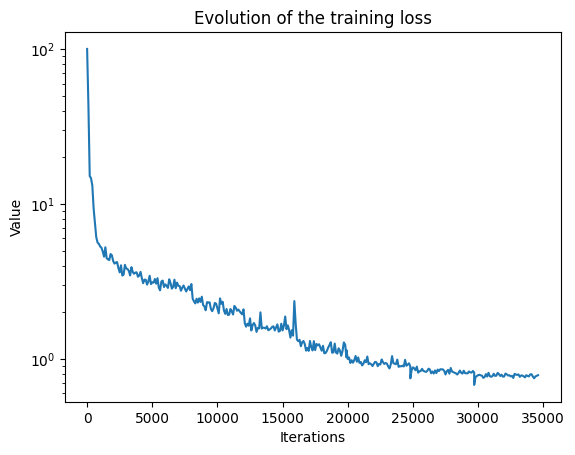

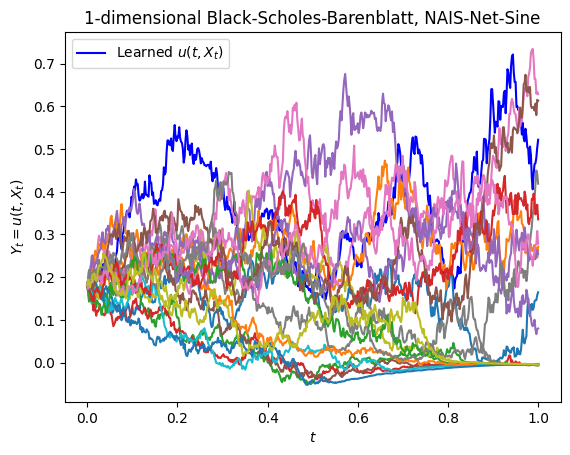

In [14]:
plt.figure()
plt.plot(graph[0], graph[1])
plt.xlabel('Iterations')
plt.ylabel('Value')
plt.yscale("log")
plt.title('Evolution of the training loss')
samples = 20
plt.figure()
plt.plot(t_test[0:1, :, 0].T, Y_pred[0:1, :, 0].T, 'b', label='Learned $u(t,X_t)$')

plt.plot(t_test[1:samples, :, 0].T, Y_pred[1:samples, :, 0].T)

plt.xlabel('$t$')
plt.ylabel('$Y_t = u(t,X_t)$')
plt.title(str(D) + '-dimensional Black-Scholes-Barenblatt, ' + model.mode + "-" + model.activation)
plt.legend()

plt.show()

In [16]:
Y_pred.shape

(8192, 501, 1)

In [17]:
r = 0.05

In [18]:
Y_preds = Y_pred.reshape(8192,501)

In [19]:
time_stamps = t_test[0].reshape(501,)
time_stamps

array([0.   , 0.002, 0.004, 0.006, 0.008, 0.01 , 0.012, 0.014, 0.016,
       0.018, 0.02 , 0.022, 0.024, 0.026, 0.028, 0.03 , 0.032, 0.034,
       0.036, 0.038, 0.04 , 0.042, 0.044, 0.046, 0.048, 0.05 , 0.052,
       0.054, 0.056, 0.058, 0.06 , 0.062, 0.064, 0.066, 0.068, 0.07 ,
       0.072, 0.074, 0.076, 0.078, 0.08 , 0.082, 0.084, 0.086, 0.088,
       0.09 , 0.092, 0.094, 0.096, 0.098, 0.1  , 0.102, 0.104, 0.106,
       0.108, 0.11 , 0.112, 0.114, 0.116, 0.118, 0.12 , 0.122, 0.124,
       0.126, 0.128, 0.13 , 0.132, 0.134, 0.136, 0.138, 0.14 , 0.142,
       0.144, 0.146, 0.148, 0.15 , 0.152, 0.154, 0.156, 0.158, 0.16 ,
       0.162, 0.164, 0.166, 0.168, 0.17 , 0.172, 0.174, 0.176, 0.178,
       0.18 , 0.182, 0.184, 0.186, 0.188, 0.19 , 0.192, 0.194, 0.196,
       0.198, 0.2  , 0.202, 0.204, 0.206, 0.208, 0.21 , 0.212, 0.214,
       0.216, 0.218, 0.22 , 0.222, 0.224, 0.226, 0.228, 0.23 , 0.232,
       0.234, 0.236, 0.238, 0.24 , 0.242, 0.244, 0.246, 0.248, 0.25 ,
       0.252, 0.254,

In [20]:
epe = np.mean(np.exp(-r*time_stamps) * np.maximum(Y_preds,0),axis=0)    
epe

array([0.17895257, 0.17896815, 0.17901129, 0.17903937, 0.1790623 ,
       0.17908755, 0.17911476, 0.17913988, 0.17915665, 0.17916879,
       0.1791795 , 0.17918648, 0.17919293, 0.1791956 , 0.17919801,
       0.17919889, 0.17919716, 0.17919315, 0.17918777, 0.17918241,
       0.17917478, 0.17916478, 0.17915474, 0.17914005, 0.17912523,
       0.17911266, 0.17909409, 0.1790799 , 0.17906807, 0.17905149,
       0.17903626, 0.17902078, 0.17900015, 0.17898184, 0.17896217,
       0.1789438 , 0.17892958, 0.17891467, 0.17889878, 0.17888196,
       0.17886254, 0.17884523, 0.17883006, 0.17881472, 0.1788006 ,
       0.17878658, 0.1787728 , 0.17875846, 0.17874601, 0.17873487,
       0.17872408, 0.17871535, 0.17870636, 0.17869724, 0.17868926,
       0.17867942, 0.17867374, 0.17866756, 0.17866409, 0.17866178,
       0.17866048, 0.1786605 , 0.17866133, 0.17866232, 0.17866604,
       0.17867179, 0.17867675, 0.17868401, 0.17869082, 0.17869963,
       0.17870945, 0.1787207 , 0.17873496, 0.17874779, 0.17876

In [21]:
ene = np.mean(np.minimum(Y_preds,0),axis=0)
ene

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [22]:
from scipy.stats import multivariate_normal as normal

In [23]:
d1 = (np.log(1) + (0.05 + 0.5 * 0.4 ** 2) * (1 - 0) ) / (0.4 * np.sqrt(1 - 0))
d2 = (np.log(1) + (0.05 - 0.5 * 0.4 ** 2) * (1 - 0) ) / (0.4 * np.sqrt(1 - 0))

call = (1 * normal.cdf(d1, 0.0, 1.0) - 1 * np.exp(-0.05 * (1 - 0) ) * normal.cdf(d2, 0.0, 1.0))

In [24]:
call

0.18022951450216668

In [25]:
epe_exact = np.array([call for s in time_stamps[1:]])
ene_exact = np.array([0.0 for s in time_stamps[1:]])

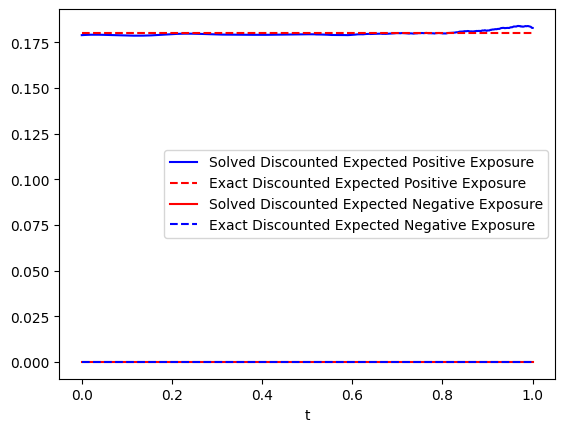

In [26]:
fig = plt.figure()
plt.plot(time_stamps,np.transpose(epe),'b',label='Solved Discounted Expected Positive Exposure' )
plt.plot(time_stamps,[call] + list(epe_exact),'r--',label='Exact Discounted Expected Positive Exposure')
plt.plot(time_stamps,np.transpose(ene),'r',label='Solved Discounted Expected Negative Exposure')
plt.plot(time_stamps,[0.0]+list(ene_exact),'b--',label='Exact Discounted Expected Negative Exposure')

plt.xlabel('t')
plt.legend()

plt.show()

In [40]:
model.save_model("models/CallOption.pth")